# Variational Autoencoders - Fashion-MNIST

adapted from: https://keras.io/examples/generative/vae/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras.backend as K

2023-08-28 10:04:33.315810: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-28 10:04:33.979260: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
from tensorflow.keras import (
    layers,
    models,
    datasets,
    callbacks,
    losses,
    optimizers,
    metrics
)

In [3]:
from scipy.stats import norm
from notebooks.utils import display

## Customize Setup

In [4]:
! pip install --no-index -f https://github.com/dreoporto/ptmlib/releases ptmlib

Looking in links: https://github.com/dreoporto/ptmlib/releases


In [5]:
from ptmlib.time import Stopwatch, AlertSounds
import ptmlib.charts as pch

In [6]:
main_stopwatch = Stopwatch()
main_stopwatch.start()

Start Time: Mon Aug 28 10:04:38 2023


## 0. Parameters

In [7]:
IMAGE_SIZE = 32
BATCH_SIZE = 100
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 5
BETA = 5000

## 1. Prepare the Data

In [8]:
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [9]:
def preprocess(imgs):
    """
    Normalize and reshape the images
    """
    imgs = imgs.astype('float32') / 255.0
    imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
    imgs = np.expand_dims(imgs, -1)
    return imgs

In [10]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

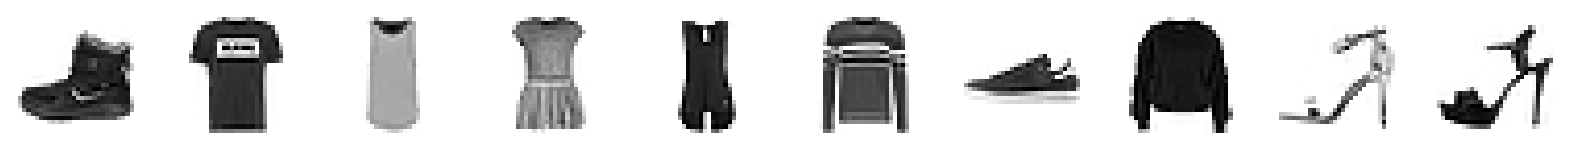

In [11]:
display(x_train)

## 2. Build the Variational Autoencoder

In [12]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [13]:
encoder_input = layers.Input(
    shape=(IMAGE_SIZE, IMAGE_SIZE, 1), name='encoder_input'
)

x = layers.Conv2D(32, (3, 3), strides=2, activation='relu', padding='same')(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
shape_before_flattening = K.int_shape(x)[1:] # used in decoder

x = layers.Flatten()(x)
z_mean = layers.Dense(EMBEDDING_DIM, name='z_mean')(x)
z_log_var = layers.Dense(EMBEDDING_DIM, name='z_log_var')(x)
z = Sampling()([z_mean, z_log_var])

encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

2023-08-28 10:04:39.961090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-28 10:04:39.977693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-28 10:04:39.978072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-28 10:04:39.979067: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 128)    73856       ['conv2d_1[0][0]']               
                                                                                            

ut NUMA support.
2023-08-28 10:04:39.981156: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-28 10:04:39.981395: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-28 10:04:42.986430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-28 10:04:42.987210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-08-28 10:04:42.987226: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1700

### Decoder

In [14]:
decoder_input = layers.Input(shape=(EMBEDDING_DIM,), name='decoder_input')

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(x)

decoder_output = layers.Conv2D(
    1,
    (3, 3),
    strides=1,
    activation='sigmoid',
    padding='same',
    name='decoder_output'
)(x)

decoder = models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 2048)              6144      
                                                                 
 reshape (Reshape)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        147584    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 64)       73792     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 32, 32, 32)       18464 

### VAE

In [15]:
class VAE(models.Model):

    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = metrics.Mean(name='kl_loss')

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker
        ]
    
    def call(self, inputs):
        """Call the model on a particular input"""
        z_mean, z_log_var, z = encoder(inputs)
        reconstruction = decoder(z)
        return z_mean, z_log_var, reconstruction
    
    def train_step(self, data):
        """Steps run during training."""
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
            kl_loss = tf.reduce_mean(
                tf.reduce_sum(
                    -0.5
                    * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                    axis=1
                )
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}
    
    def test_step(self, data):
        """Step run during validation"""
        if isinstance(data, tuple):
            data = data[0]
        
        z_mean, z_log_var, reconstruction = self(data)
        reconstruction_loss = tf.reduce_mean(
                BETA
                * losses.binary_crossentropy(
                    data, reconstruction, axis=(1, 2, 3)
                )
            )
        kl_loss = tf.reduce_mean(
            tf.reduce_sum(
                -0.5
                * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)),
                axis=1
            )
        )
        total_loss = reconstruction_loss + kl_loss

        return {
            'loss': total_loss,
            'reconstruction_loss': reconstruction_loss,
            'kl_loss': kl_loss
        }

In [16]:
vae = VAE(encoder, decoder)

## 3. Train the VAE

In [17]:
optimizer = optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer)

In [18]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath='./checkpoint',
    save_weights_only=False,
    save_freq='epoch',
    monitor='loss',
    mode='min',
    save_best_only=True,
    verbose=0
)

tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')

In [19]:
stopwatch = Stopwatch()
stopwatch.start()

history = vae.fit(
    x_train,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=[model_checkpoint_callback, tensorboard_callback]
)

stopwatch.stop()

Start Time: Mon Aug 28 10:04:43 2023
Epoch 1/5


2023-08-28 10:04:46.871925: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


600/600 [==============================] - 14s 14ms/step - total_loss: 1588.1165 - reconstruction_loss: 1577.7590 - kl_loss: 10.3564 - val_loss: 1378.3937 - val_reconstruction_loss: 1369.9163 - val_kl_loss: 8.4774
Epoch 2/5
600/600 [==============================] - 8s 13ms/step - total_loss: 1311.2529 - reconstruction_loss: 1302.6692 - kl_loss: 8.5850 - val_loss: 1329.6844 - val_reconstruction_loss: 1321.2354 - val_kl_loss: 8.4491
Epoch 3/5
600/600 [==============================] - 8s 13ms/step - total_loss: 1289.8876 - reconstruction_loss: 1281.5601 - kl_loss: 8.3268 - val_loss: 1316.5016 - val_reconstruction_loss: 1308.1692 - val_kl_loss: 8.3323
Epoch 4/5
600/600 [==============================] - 8s 14ms/step - total_loss: 1280.1785 - reconstruction_loss: 1271.9154 - kl_loss: 8.2627 - val_loss: 1307.3618 - val_reconstruction_loss: 1298.8450 - val_kl_loss: 8.5168
Epoch 5/5
600/600 [==============================] - 8s 14ms/step - total_loss: 1273.2383 - reconstruction_loss: 1265.01

Saved image: total_loss-20230828-100530.png


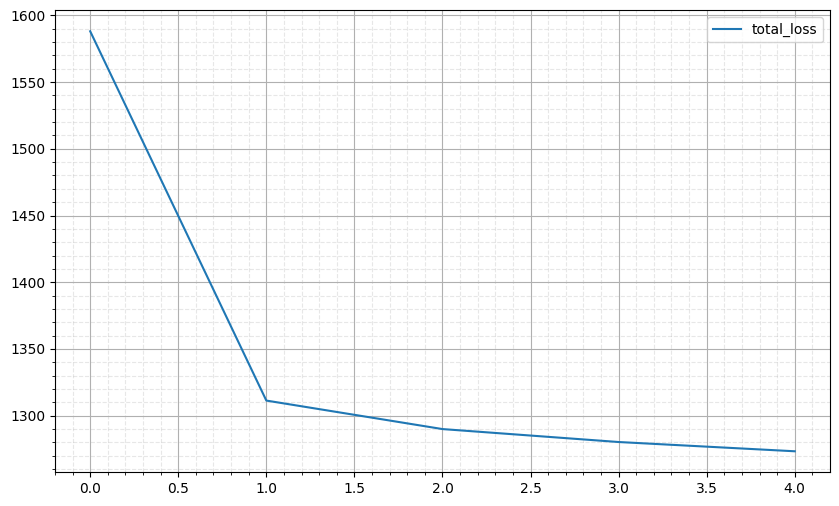

In [20]:
pch.show_history_chart(history, "total_loss", save_fig_enabled=True)

Saved image: loss-20230828-100531.png


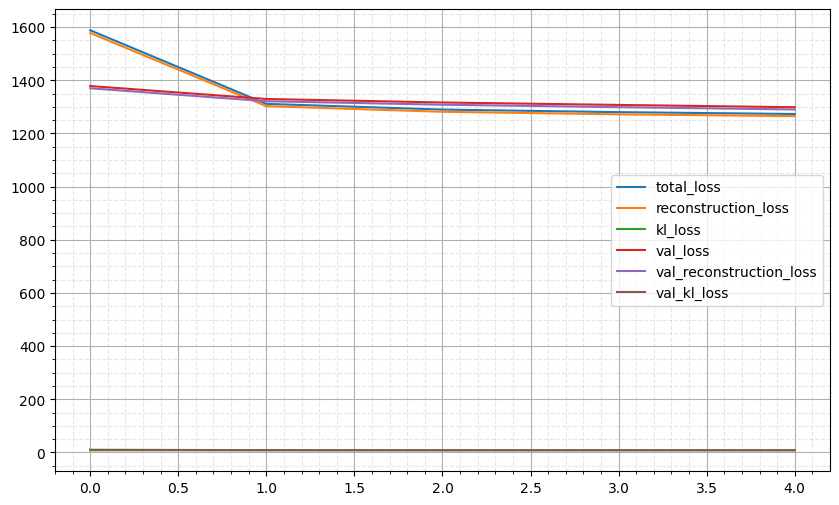

In [21]:
pch.show_history_chart(history, "loss", save_fig_enabled=True)

In [22]:
vae.save('./models/vae')
encoder.save('./models/encoder')
decoder.save('./models/decoder')

INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/vae/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/encoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


INFO:tensorflow:Assets written to: ./models/decoder/assets


### Reconstruct using the VAE

In [23]:
n_to_predict = 5000
example_images = x_test[:n_to_predict]
example_labels = y_test[:n_to_predict]

157/157 [==============================] - 1s 3ms/step
Example real clothing items


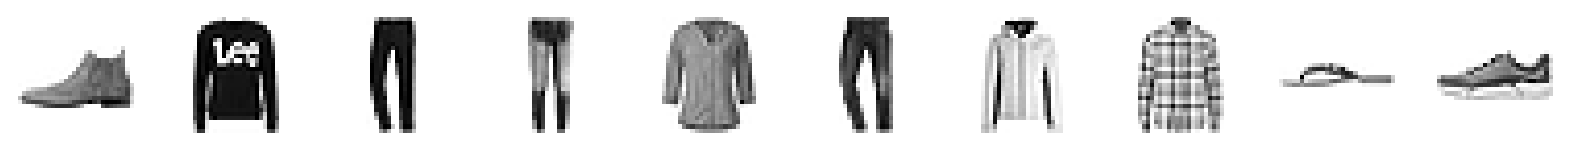

Reconstructions


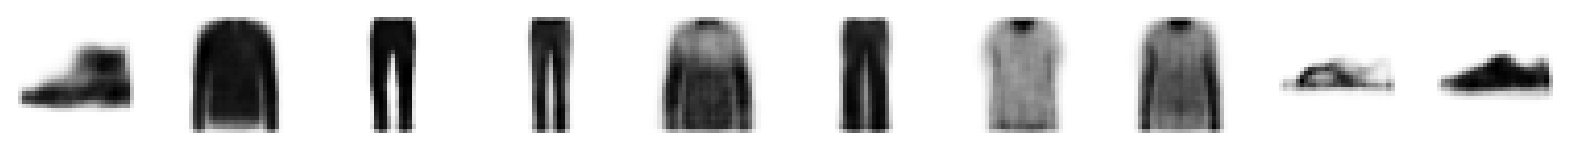

In [24]:
z_mean, z_log_var, reconstructions = vae.predict(example_images)
print('Example real clothing items')
display(example_images)
print('Reconstructions')
display(reconstructions)